# PySparkによる週販累計

In [2]:
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType, TimestampType, StringType
from pyspark.sql.window import Window
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.utils import AnalysisException
import pandas as pd
import datetime
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import japanize_matplotlib

# spark initialization
spark = SparkSession.builder.appName("gamedata").getOrCreate()
# load master database
hard_weekly_df = spark.read.parquet("../database/parquet/hard_weekly")

## ハード毎､日付順で累計する

- hwでパーティション分離､日付順で､Windowの先頭から現在位置までのWindowを作る
- 上記のWindowsを使ってunitsを合計し､cumsumカラムとして追加
- end_date順に並べる

In [6]:
w = Window.partitionBy("hw").orderBy("end_date").rangeBetween(Window.unboundedPreceding, 0)
hard_sum = hard_weekly_df.withColumn("cumsum", F.sum("units").over(w)).sort("end_date")

## hw毎にpivotする

In [12]:
hard_cumsum = hard_sum.groupBy("end_date").pivot("hw").sum("cumsum").sort("end_date")

## データ範囲に発売日を含まないものを除く

In [14]:
hard_cumsum = hard_cumsum.select("end_date",
    "PS5", "XSX", "Switch",
    "XBOne", "PS4", "WiiU",
    "Vita", "3DS", 
    "Wii", "PS3", "XB360",
    "DS", "PSP",
    "Xbox", "GC", "GBA", "PS2",
    "WS", "PKS", "DC", "NeoGeoP") 

## pandas DFに変換してplot

In [17]:
pdf = hard_cumsum.toPandas().set_index("end_date")

<AxesSubplot:xlabel='end_date'>

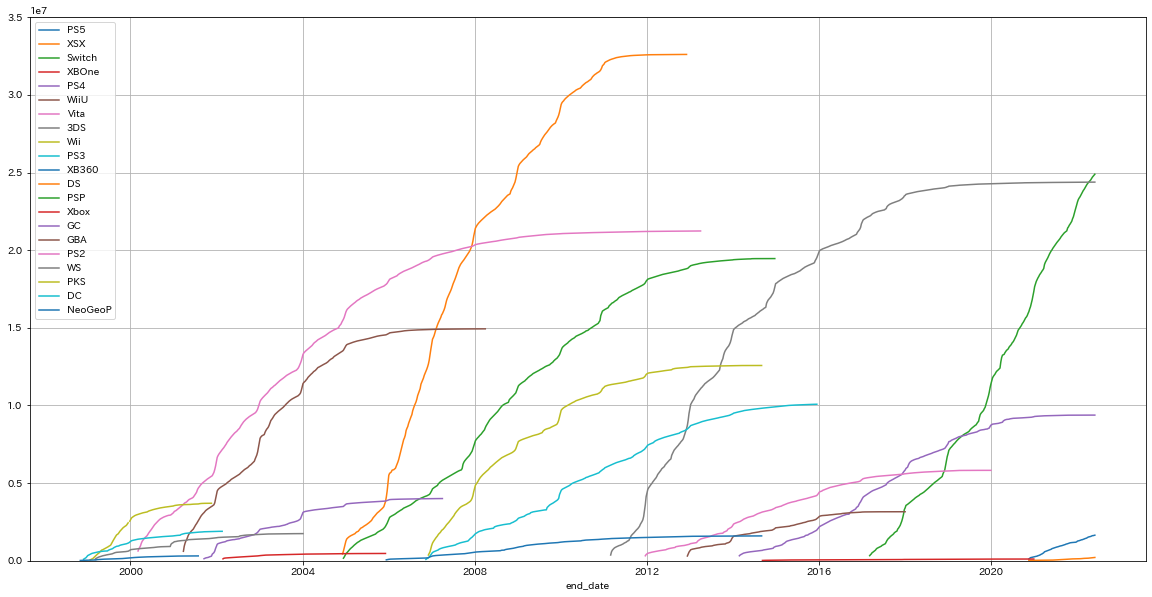

In [19]:
pdf.plot(figsize=(20, 10), grid=True, kind="line", ylim=[0, 35000000])